<a href="https://colab.research.google.com/github/haidernawaz108/AI-PROJECT-2025/blob/main/NOTEBOOK/FINAL_PHASE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DATA LOADING AND EXPLORATION**

**INSTALLING REQUIRED LIBRARIES**

In [ ]:
!pip install -q tensorflow keras numpy matplotlib seaborn scikit-learn pillow


**EXTRACTING DATASET**

In [ ]:
!unzip -oq "/content/brain-tumor/data.zip" -d "/content/data.zip/"


unzip:  cannot find or open /content/brain-tumor/data.zip, /content/brain-tumor/data.zip.zip or /content/brain-tumor/data.zip.ZIP.


**COPYING EXTRACTED DATASET TO DRIVE**

In [ ]:
!rsync -av --progress "/content/data.zip/Brain_Cancer/" "/content/drive/MyDrive/datasets/brain_cancer/"


sending incremental file list
rsync: [sender] change_dir "/content/data.zip/Brain_Cancer" failed: No such file or directory (2)

sent 19 bytes  received 12 bytes  20.67 bytes/sec
total size is 0  speedup is 0.00
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


**CHECKING FOLDERS IN DRIVE**

In [ ]:
import os

base_dir = "/content/drive/MyDrive/datasets/brain_cancer"
print(os.listdir(base_dir))


['brain_glioma', 'brain_menin', 'brain_tumor', 'manifest.csv']


**COUNTING IMAGES IN EACH CLASS**

In [ ]:
for cls in os.listdir(base_dir):
    path = os.path.join(base_dir, cls)
    if os.path.isdir(path):
        n = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
        print(f"{cls}: {n}")


brain_glioma: 2004
brain_menin: 2004
brain_tumor: 2048


**DISPLAYING SAMPLE IMAGES OF EACH CLASS**

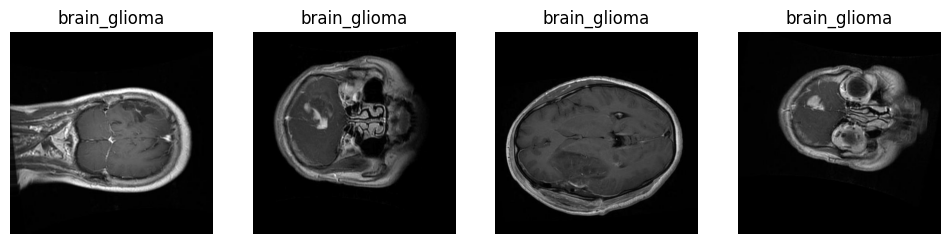

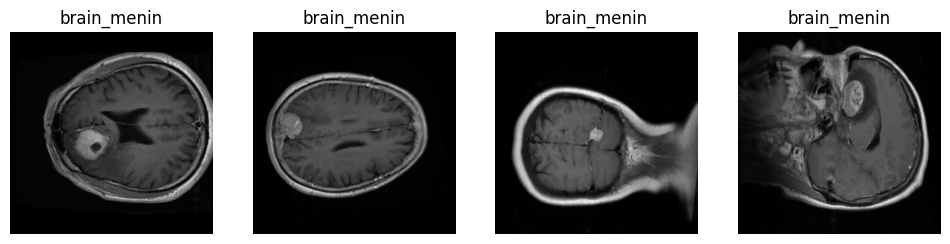

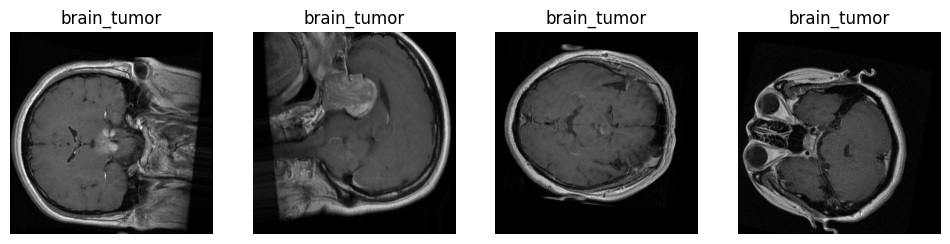

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random, os

def show_samples(base, n=4):
    classes = [d for d in os.listdir(base) if os.path.isdir(os.path.join(base,d))]

    for cls in classes:
        folder = os.path.join(base, cls)
        imgs = [f for f in os.listdir(folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
        sample = random.sample(imgs, min(n, len(imgs)))

        plt.figure(figsize=(12,3))
        for i, imgfile in enumerate(sample):
            img = Image.open(os.path.join(folder, imgfile))
            plt.subplot(1, n, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(cls)
            plt.axis("off")
        plt.show()

show_samples(base_dir, 4)


**CHECKING IMAGES COMMON SIZE**

In [ ]:
from PIL import Image
from collections import Counter

sizes = Counter()
limit = 2000  # analyze first 2000 images

count = 0
for cls in os.listdir(base_dir):
    folder = os.path.join(base_dir, cls)
    if not os.path.isdir(folder):
        continue
    for img in os.listdir(folder):
        if img.lower().endswith(('.jpg','.jpeg','.png')):
            try:
                im = Image.open(os.path.join(folder, img))
                sizes[im.size] += 1
            except:
                pass
            count += 1
            if count >= limit:
                break
    if count >= limit:
        break

print("Most common image sizes:")
print(sizes.most_common(20))


Most common image sizes:
[((512, 512), 2000)]


**CREATING CSV FILE FOR REPORT**

In [ ]:
import pandas as pd

rows = []

for cls in os.listdir(base_dir):
    path = os.path.join(base_dir, cls)
    if os.path.isdir(path):
        for img in os.listdir(path):
            if img.lower().endswith(('.jpg','.jpeg','.png')):
                rows.append({
                    "class": cls,
                    "path": os.path.join(path, img)
                })

df = pd.DataFrame(rows)
df.to_csv(base_dir + "/manifest.csv", index=False)

df.head()


,class,path
0,brain_glioma,/content/drive/MyDrive/datasets/brain_cancer/b...
1,brain_glioma,/content/drive/MyDrive/datasets/brain_cancer/b...
2,brain_glioma,/content/drive/MyDrive/datasets/brain_cancer/b...
3,brain_glioma,/content/drive/MyDrive/datasets/brain_cancer/b...
4,brain_glioma,/content/drive/MyDrive/datasets/brain_cancer/b...


**SPLITTING DATASET INTO TRAIN/VAL/TEST**

In [ ]:
import os, shutil
from sklearn.model_selection import train_test_split
source = "/content/drive/MyDrive/datasets/brain_cancer"
target = "/content/drive/MyDrive/datasets/brain_cancer_split"
classes = ["brain_glioma", "brain_menin", "brain_tumor"]

# 1) Create split folder structure
for sp in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(f"{target}/{sp}/{cls}", exist_ok=True)
# 2) Create splits and FAST copy
for cls in classes:
    cls_path = f"{source}/{cls}"
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    # 70/15/15 split
    train_split, temp = train_test_split(images, test_size=0.30, random_state=42)
    val_split, test_split = train_test_split(temp, test_size=0.50, random_state=42)
    # fast copy (shutil.copy = stable + no hang)
    for img in train_split:
        shutil.copy(f"{cls_path}/{img}", f"{target}/train/{cls}/{img}")
    for img in val_split:
        shutil.copy(f"{cls_path}/{img}", f"{target}/val/{cls}/{img}")
    for img in test_split:
        shutil.copy(f"{cls_path}/{img}", f"{target}/test/{cls}/{img}")
print("Train/Val/Test split completed successfully!")


**COUNTING IMAGES IN TRAIN/VAL/TEST**

In [ ]:
import os

base = "/content/drive/MyDrive/datasets/brain_cancer_split"

for split in ["train", "val", "test"]:
    print(f"\n=== {split.upper()} ===")
    for cls in os.listdir(os.path.join(base, split)):
        path = os.path.join(base, split, cls)
        print(cls, "→", len(os.listdir(path)))



=== TRAIN ===
brain_glioma → 1829
brain_menin → 1709
brain_tumor → 1433

=== VAL ===
brain_glioma → 565
brain_menin → 301
brain_tumor → 307

=== TEST ===
brain_glioma → 553
brain_menin → 301
brain_tumor → 308


**SHOWING SAMPLE IMAGES**

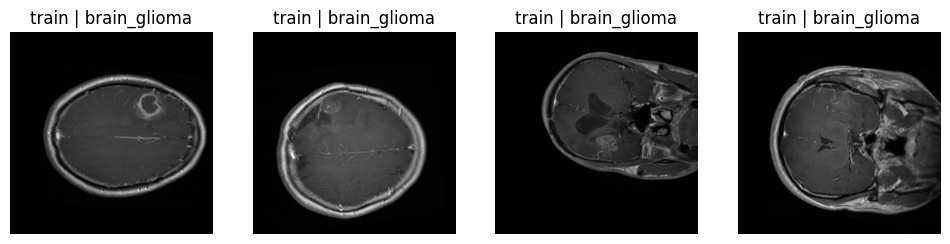

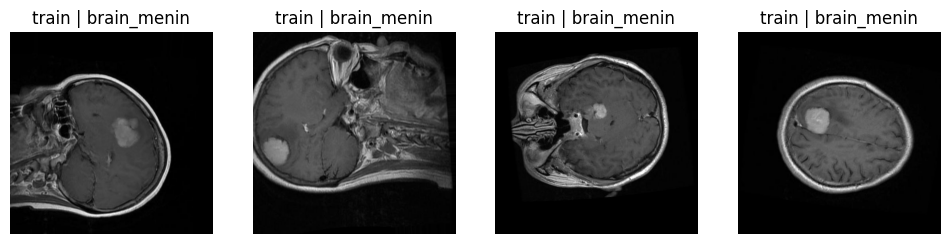

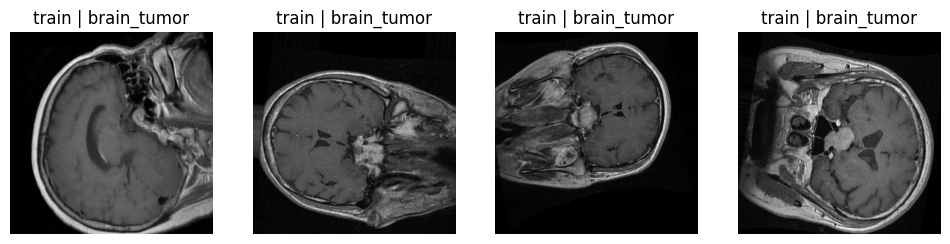

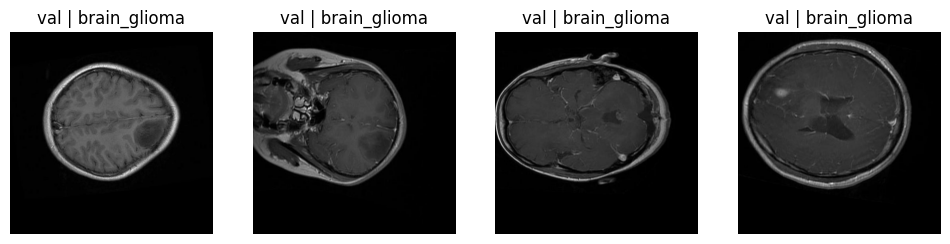

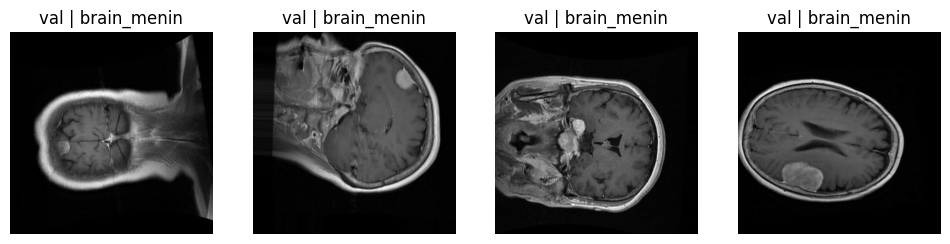

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random, os

def show_samples_from_split(base, split="train", n=4):
    split_dir = os.path.join(base, split)
    classes = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir,d))]
    for cls in classes:
        folder = os.path.join(split_dir, cls)
        imgs = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]
        sample = random.sample(imgs, min(n,len(imgs)))
        plt.figure(figsize=(12,3))
        for i,fn in enumerate(sample):
            img = Image.open(os.path.join(folder,fn)).convert("RGB")
            plt.subplot(1,n,i+1)
            plt.imshow(img)
            plt.title(f"{split} | {cls}")
            plt.axis("off")
        plt.show()

show_samples_from_split(base, "train", 4)
show_samples_from_split(base, "val", 4)
show_samples_from_split(base, "test", 4)


**LOADING DATASET**

In [3]:
import tensorflow as tf
BATCH_SIZE = 32
IMG_SIZE = (224,224)
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base,"train"),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical", shuffle=True, seed=42
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base,"val"),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical", shuffle=False
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base,"test"),
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode="categorical", shuffle=False
)
class_names = train_ds.class_names
print("Classes:", class_names)


Found 4971 files belonging to 3 classes.
Found 1173 files belonging to 3 classes.
Found 1162 files belonging to 3 classes.
Classes: ['brain_glioma', 'brain_menin', 'brain_tumor']


**OPTIMIZE DATA LOADING**

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


**DATA AUGMENTATION LAYER**

In [5]:
from tensorflow.keras import layers, Sequential
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.06),
], name="data_augmentation")


**BUILDING MODEL ARCHITECTURE**

In [6]:
from tensorflow.keras import Input, Model
base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(*IMG_SIZE,3), weights="imagenet")
base_model.trainable = False

inputs = Input(shape=(*IMG_SIZE,3))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,926 (16.07 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

**TRAINING CALLBACK SETUPS**

In [7]:
import os
ckpt = "/content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5"
os.makedirs(os.path.dirname(ckpt), exist_ok=True)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt, monitor="val_loss", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
]


**INITIAL MODEL TRAINING**

In [8]:
EPOCHS = 12
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)


Epoch 1/12
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7426 - loss: 0.5902 
Epoch 1: val_loss improved from inf to 0.23773, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 2256s 14s/step - accuracy: 0.7431 - loss: 0.5893 - val_accuracy: 0.9139 - val_loss: 0.2377 - learning_rate: 0.0010
Epoch 2/12
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8725 - loss: 0.3338
Epoch 2: val_loss did not improve from 0.23773
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.8725 - loss: 0.3337 - val_accuracy: 0.9105 - val_loss: 0.2378 - learning_rate: 0.0010
Epoch 3/12
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8957 - loss: 0.2780
Epoch 3: val_loss improved from 0.23773 to 0.19112, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.8957 - loss: 0.2780 - val_accuracy: 0.9318 - val_loss: 0.1911 - learning_rate: 0.0010
Epoch 4/12
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8971 - loss: 0.2660
Epoch 4: val_loss did not improve from 0.19112
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.8971 - loss: 0.2659 - val_accuracy: 0.9071 - val_loss: 0.2183 - learning_rate: 0.0010
Epoch 5/12
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9024 - loss: 0.2403
Epoch 5: val_loss did not improve from 0.19112
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9024 - loss: 0.2403 - val_accuracy: 0.9224 - val_loss: 0.1926 - learning_rate: 0.0010
Epoch 6/12
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9180 - loss: 0.2094
Epoch 6: val_loss did not improve from 0.19112

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9180 - loss: 0.2095 - val_accuracy:

156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.9211 - loss: 0.2075 - val_accuracy: 0.9216 - val_loss: 0.1865 - learning_rate: 5.0000e-04
Epoch 8/12
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9222 - loss: 0.1979
Epoch 8: val_loss improved from 0.18650 to 0.17940, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.9222 - loss: 0.1979 - val_accuracy: 0.9318 - val_loss: 0.1794 - learning_rate: 5.0000e-04
Epoch 9/12
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9221 - loss: 0.1966
Epoch 9: val_loss did not improve from 0.17940
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9222 - loss: 0.1965 - val_accuracy: 0.9216 - val_loss: 0.2025 - learning_rate: 5.0000e-04
Epoch 10/12
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9304 - loss: 0.1777
Epoch 10: val_loss did not improve from 0.17940
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.9303 - loss: 0.1778 - val_accuracy: 0.9250 - val_loss: 0.2040 - learning_rate: 5.0000e-04
Epoch 11/12
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9344 - loss: 0.1758
Epoch 11: val_loss improved from 0.17940 to 0.17852, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.9343 - loss: 0.1760 - val_accuracy: 0.9309 - val_loss: 0.1785 - learning_rate: 5.0000e-04
Epoch 12/12
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9317 - loss: 0.1649
Epoch 12: val_loss improved from 0.17852 to 0.17448, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.9317 - loss: 0.1650 - val_accuracy: 0.9318 - val_loss: 0.1745 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 12.


**MODEL FINE-TUNNING**

In [9]:
base_model.trainable = True

fine_tune_at = len(base_model.layers) - 40
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_FINE = 10

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINE,
    callbacks=callbacks
)


Epoch 1/10
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8106 - loss: 0.5475
Epoch 1: val_loss did not improve from 0.17448
156/156 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.8110 - loss: 0.5461 - val_accuracy: 0.9292 - val_loss: 0.1780 - learning_rate: 1.0000e-05
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8840 - loss: 0.3038
Epoch 2: val_loss improved from 0.17448 to 0.15889, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.8840 - loss: 0.3037 - val_accuracy: 0.9395 - val_loss: 0.1589 - learning_rate: 1.0000e-05
Epoch 3/10
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8887 - loss: 0.2883
Epoch 3: val_loss improved from 0.15889 to 0.14594, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.8887 - loss: 0.2881 - val_accuracy: 0.9454 - val_loss: 0.1459 - learning_rate: 1.0000e-05
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9005 - loss: 0.2567
Epoch 4: val_loss improved from 0.14594 to 0.13479, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.9005 - loss: 0.2566 - val_accuracy: 0.9471 - val_loss: 0.1348 - learning_rate: 1.0000e-05
Epoch 5/10
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9119 - loss: 0.2333
Epoch 5: val_loss improved from 0.13479 to 0.12711, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.9119 - loss: 0.2332 - val_accuracy: 0.9514 - val_loss: 0.1271 - learning_rate: 1.0000e-05
Epoch 6/10
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9142 - loss: 0.2198
Epoch 6: val_loss improved from 0.12711 to 0.11843, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9142 - loss: 0.2197 - val_accuracy: 0.9540 - val_loss: 0.1184 - learning_rate: 1.0000e-05
Epoch 7/10
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9217 - loss: 0.2022
Epoch 7: val_loss improved from 0.11843 to 0.11363, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.9217 - loss: 0.2022 - val_accuracy: 0.9557 - val_loss: 0.1136 - learning_rate: 1.0000e-05
Epoch 8/10
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9271 - loss: 0.1850
Epoch 8: val_loss improved from 0.11363 to 0.10530, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - accuracy: 0.9272 - loss: 0.1849 - val_accuracy: 0.9574 - val_loss: 0.1053 - learning_rate: 1.0000e-05
Epoch 9/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9259 - loss: 0.1799
Epoch 9: val_loss improved from 0.10530 to 0.09622, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9259 - loss: 0.1799 - val_accuracy: 0.9616 - val_loss: 0.0962 - learning_rate: 1.0000e-05
Epoch 10/10
155/156 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9358 - loss: 0.1676
Epoch 10: val_loss improved from 0.09622 to 0.09550, saving model to /content/drive/MyDrive/datasets/brain_cancer_models/effnet_ckpt.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - accuracy: 0.9357 - loss: 0.1676 - val_accuracy: 0.9616 - val_loss: 0.0955 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 10.


**ACCURACY & LOSS GRAPHS**

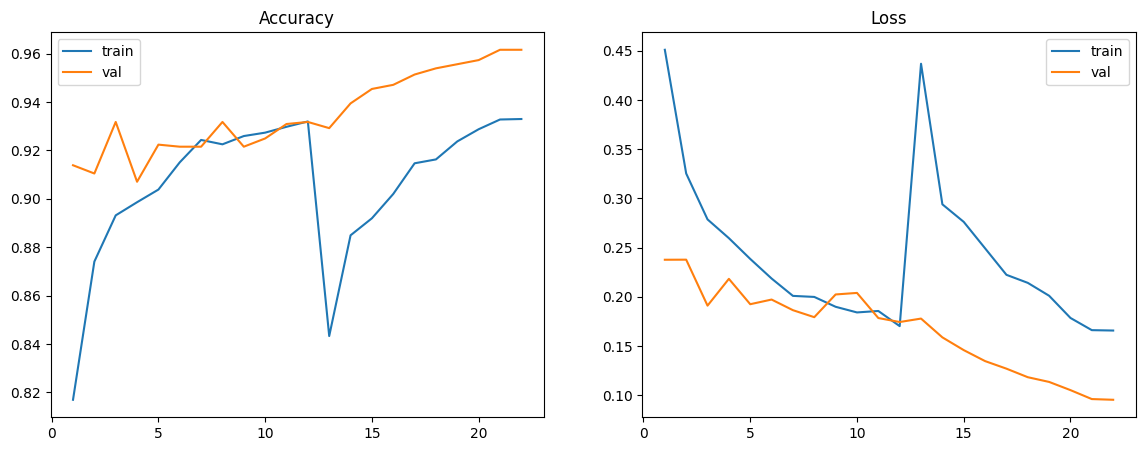

In [10]:
import matplotlib.pyplot as plt
def plot_history(h1, h2=None):
    acc = h1.history.get("accuracy", [])
    val_acc = h1.history.get("val_accuracy", [])
    loss = h1.history.get("loss", [])
    val_loss = h1.history.get("val_loss", [])
    if h2:
        acc += h2.history.get("accuracy", [])
        val_acc += h2.history.get("val_accuracy", [])
        loss += h2.history.get("loss", [])
        val_loss += h2.history.get("val_loss", [])
    epochs = range(1, len(acc)+1)
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="train")
    plt.plot(epochs, val_acc, label="val")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="train")
    plt.plot(epochs, val_loss, label="val")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history(history, history_fine)


**ACCURACY & CONFUSION MATRIX**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

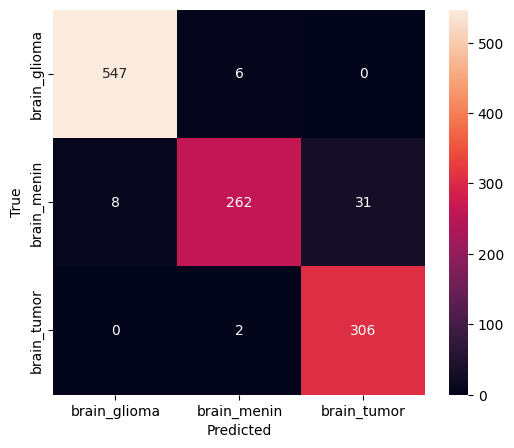

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("Test Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**PREDICTION RESULT VISUALIZATION**

Model saved at: /content/drive/MyDrive/datasets/brain_cancer_models/effnet_final.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


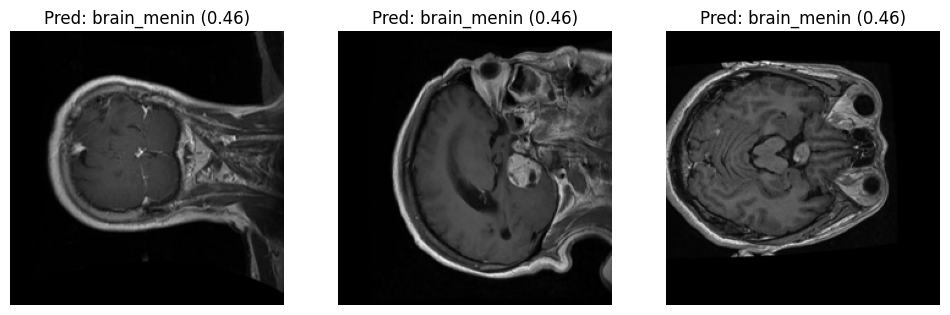

In [12]:
final_path = "/content/drive/MyDrive/datasets/brain_cancer_models/effnet_final.h5"
model.save(final_path)
print("Model saved at:", final_path)

import random
from PIL import Image

test_root = os.path.join(base, "test")
samples = []

for cls in class_names:
    cls_dir = os.path.join(test_root, cls)
    imgs = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    if imgs:
        samples.append(os.path.join(cls_dir, random.choice(imgs)))

plt.figure(figsize=(12,4))
for i, p in enumerate(samples):
    im = Image.open(p).convert("RGB").resize(IMG_SIZE)
    arr = np.expand_dims(np.array(im)/255.0, axis=0)
    pred = model.predict(arr)
    pi = np.argmax(pred)
    plt.subplot(1, len(samples), i+1)
    plt.imshow(im)
    plt.title(f"Pred: {class_names[pi]} ({pred[0][pi]:.2f})")
    plt.axis("off")
plt.show()
